In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import minimize

In [2]:
g = 980.66 # cm * s-2

def rho(T):
    rho_10 = 0.8724 # g * cm-3
    rho_30 = 0.8606 # g * cm-3
    rho_T = (T-10) / 20 * (rho_30 - rho_10) + rho_10
    return rho_T

L = 0.12 # cm 

D = 0.45 # cm

def get_V(V):
    # [V_s] = V = kg m2 s-3 A-1
    return V * 1e3 * 1e4 # V = g cm2 s-3 A-1

def eta(T):
    eta_20 = 1.81920e-5 # kg / m / s
    eta_coeff = 0.0494e-6
    eta_T = eta_20 + eta_coeff * (T-20)
    return eta_T * 10 # g / cm / s

def rho_a(T):
    rho_20 = 0.001205 # g / cm^3
    return rho_20

e = 1.602e-19
b = .000617
p = 76

In [3]:
def K2(T):
    eta_T = eta(T)
    rho_T = rho(T)
    rho_a_T = rho_a(T)
    K2_sqrt_part = eta_T**3 / 2 / (rho_T-rho_a_T) / g
    K2 = 18 * np.pi * D * np.sqrt(K2_sqrt_part)
    return K2

def a1(T, tg):
    eta_T = eta(T)
    rho_T = rho(T)
    rho_a_T = rho_a(T)
    vg = L / tg
    a1 = np.sqrt(9 * eta_T * vg / (2 * (rho_T - rho_a_T) * g))
    return a1

def K1(T, tg):
    a1_p = a1(T, tg)
    k1 = 1 + b/(a1_p * p) + 1/2 * (b/(a1_p * p)) ** 2
    K1 = k1 ** 1.5
    return a1_p, K1

In [4]:
# def K1_o(tg):
#     tg_K1 = np.array([
#         5, 1.058, 65, 1.221, 10, 1.082, 70, 1.230, 
#         15, 1.102, 75, 1.239, 20, 1.118, 80, 1.249, 
#         25, 1.132, 85, 1.258, 30, 1.146, 90, 1.267, 
#         35, 1.158, 95, 1.275, 40, 1.170, 100, 1.283, 
#         45, 1.181, 105, 1.291, 50, 1.192, 110, 1.298, 
#         55, 1.202, 115, 1.305, 60, 1.212, 120, 1.312
#     ])
#     tgs = [tg_K1[i] for i in range(len(tg_K1)) if i%2==0]
#     K1s = [tg_K1[i] for i in range(len(tg_K1)) if i%2==1]
    
#     for i in range(1, 20):
#         tgs.append(120+i*5)
#         K1s.append(1.312+i*0.007)
    
#     tgs_sorted = np.array([x for x, y in sorted(zip(tgs, K1s))])
#     K1s_sorted = np.array([y for x, y in sorted(zip(tgs, K1s))])
    
#     tgs_final = tgs_sorted / 0.2559 * L
    
# #     for tg, K1 in zip(tgs_final, K1s_sorted):
# #         print(tg, K1)

#     tgs = tgs_final
#     K1s = K1s_sorted
    
#     idx = np.abs(tgs_final - tg).argmin()
    
#     if tgs[idx] > tg:
#         idx -= 1
#     if idx == len(tgs) -1:
#         print('Error: ', tg)
#         return None
    
#     K1 = K1s[idx] + \
#         (tg - tgs[idx]) / (tgs[idx+1] - tgs[idx]) * (K1s[idx+1] - K1s[idx])
    
#     return K1

In [5]:
def calc(te, tg, V, T):
    ve = L / te
    vg = L / tg
    K2_T = K2(T)
    a1_p, K1_tg = K1(T, tg)
    V_scale = get_V(V)
    ne = K2_T * (ve + vg) * np.sqrt(vg) / V_scale / K1_tg
    n = ne / e

    dL = 0.01
    dt = 1
    dD = 0.03
    dV = 0.2

    dve = ((dL/L)**2 + (dt/te)**2)**0.5 * ve
    dvg = ((dL/L)**2 + (dt/tg)**2)**0.5 * vg
    dve_p_vg = (dve**2 + dvg**2)**0.5
    dvg_sqrt = 0.5 * dvg
    dK2 = dD/D * K2_T
    da1 = ((dvg_sqrt/vg**0.5)**2)**0.5 * a1_p
    dK1 = 1.5 * (da1 / a1_p)**0.5 * K1_tg
    # print(dve_p_vg/(ve+vg), dvg_sqrt/vg**0.5, dK2/K2_T, dK1/K1_tg, dV/V)
    dn = ((dve_p_vg/(ve+vg))**2 + (dK1/K1_tg)**2 + (dvg_sqrt/vg**0.5)**2 + (dK2/K2_T)**2 + (dV/V)**2)**0.5 * n

    return ne, n, a1_p, dn

In [6]:
df = pd.read_csv('data.csv')
Vs = df['V']
Ts = df['T']
tgs = df['tg_avg']
tes = df['te_avg']


nes, ns, a1s, dns = [], [], [], []
for V, T, tg, te in zip(Vs, Ts, tgs, tes):
    ne, n, a1p, dn = calc(te, tg, V, T)
    nes.append(ne)
    ns.append(n)
    a1s.append(a1p)
    dns.append(dn)
df['n'] = ns
df['a1'] = np.array(a1s) * 1e4
df['dn'] = dns
df['n'] = df['n'].map('{:,.2f}'.format)
df['a1'] = df['a1'].map('{:,.2f}'.format) 
df['dn'] = df['dn'].map('{:,.2f}'.format) 

In [7]:
df

,Trials,V,T,tg1,te1,tg2,te2,tg3,te3,tg_avg,te_avg,n,a1,dn
0,1,200.0,18.9,28.17,57.69,27.66,58.78,27.53,59.61,27.79,58.69,1.63,0.64,0.20
1,2,200.0,18.9,76.84,6.41,81.43,4.45,86.47,6.92,81.58,5.93,2.84,0.38,0.56
2,3,200.0,18.9,49.71,11.22,48.59,10.93,47.47,10.11,48.59,10.75,2.49,0.49,0.35
3,4,200.0,18.9,44.05,8.34,46.49,8.29,42.77,8.47,44.44,8.37,3.28,0.51,0.52
4,5,200.0,18.9,57.29,8.82,57.36,8.67,57.86,8.59,57.50,8.69,2.61,0.45,0.41
5,6,200.0,18.9,42.17,12.00,39.64,11.54,38.92,12.65,40.24,12.06,2.65,0.54,0.36
6,7,200.0,18.9,65.21,12.72,66.59,11.56,NaN,NaN,65.90,12.14,1.76,0.42,0.24
7,8,200.0,18.9,49.50,7.11,48.53,7.05,49.91,7.18,49.31,7.11,3.49,0.48,0.60
8,9,260.6,20.0,52.33,4.96,51.63,5.06,49.00,4.71,50.99,4.91,3.66,0.48,0.81
9,10,260.6,20.0,46.32,5.66,46.93,5.43,49.20,5.60,47.48,5.56,3.44,0.49,0.70


In [8]:
# x = df.to_string(header=False,
#                   index=False,
#                   index_names=False).split('\n')
# for line in x:
#     l = line.split()
#     l.insert(1, '\\vline')
#     print(' & '.join(l) + ' \\\\')

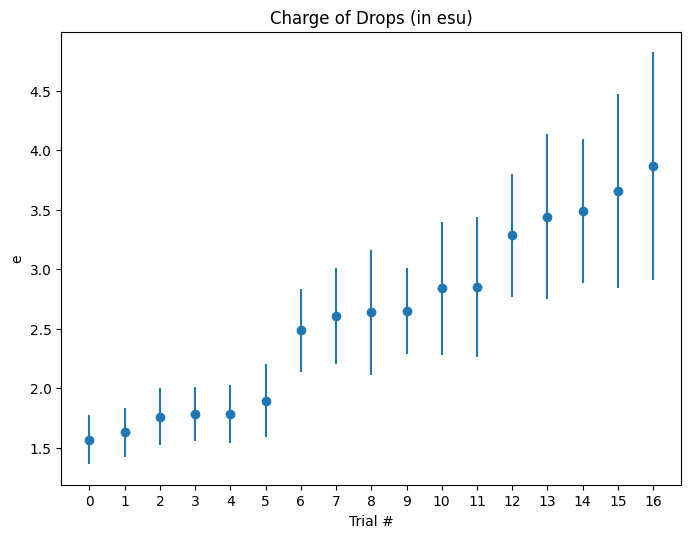

In [9]:
sorted_zip = sorted(zip(ns, dns))
ns = [item[0] for item in sorted_zip]
dns = [item[1] for item in sorted_zip]
plt.figure(figsize=(8, 6), dpi=100)
# plt.scatter(np.arange(len(ns)), ns)
plt.errorbar(np.arange(len(ns)), ns, yerr=dns, fmt="o")
plt.xticks(np.arange(0, 17, step=1))
plt.title('Charge of Drops (in esu)')
plt.xlabel('Trial #')
plt.ylabel('e')
plt.savefig('drop_charge.jpg')

In [10]:

def p1(mu, sigma, n, e):
    return scipy.stats.norm(mu, sigma).pdf(n * e)

def p2(mus, sigmas, e):
    p = 1
    for mu, sigma in zip(mus, sigmas):
        p_mu = 0
        for n in range(1, 5):
            p_1 = p1(mu, sigma, n, e)
            p_1 *= 0.25
            p_mu += p_1
        p *= p_mu
    return np.log(p)

fun = lambda e: -1 * p2(ns, dns, e)
res = minimize(fun, 1, method='Nelder-Mead')

In [11]:
res.x

array([0.8625])

In [12]:
x = np.linspace(0, 4, num=100)
y = [p2(ns, dns, e) for e in x]

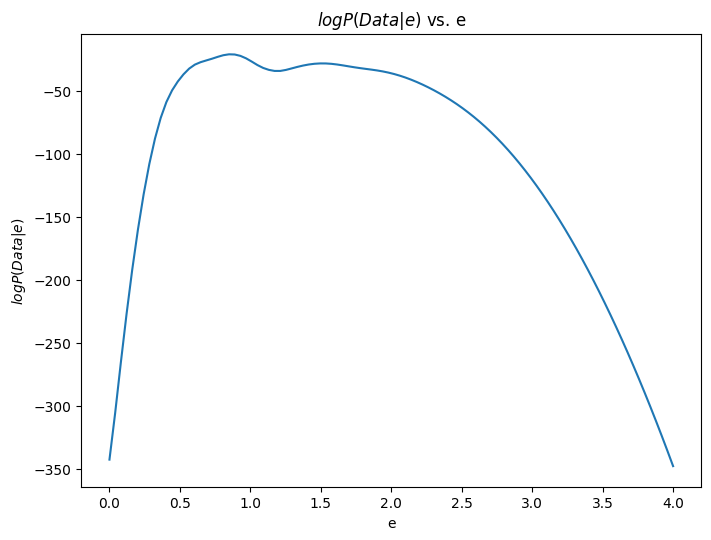

In [13]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x, y)
plt.title('$log P(Data|e)$ vs. e')
plt.ylabel('$log P(Data|e)$')
plt.xlabel('e')
plt.savefig('mle.jpg')

In [19]:
np.mean(dns)

0.4587255085760615

In [20]:
m1 = np.mean(ns[:6])
m2 = np.mean(ns[6:12])
m3 = np.mean(ns[12:])

In [21]:
m1, m2, m3, m3-m2, m2-m1, ((m3-m2) + (m2-m1))/2

(1.7380340844434343,
 2.678903449774877,
 3.5482035796714904,
 0.8693001298966134,
 0.9408693653314426,
 0.905084747614028)